In [49]:
%matplotlib inline
import os
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

from plot_utils import load_dataset_params, select_meas, plt_acc_boxscatter, comput_meas_table, add_letters, obtain_dfs
from scipy.optimize import linear_sum_assignment

In [50]:
# load model performance metrics
rootpth = './xdc_runs/'
dat_type = 'train' # 'train', test'
measure = 'acc'
dataset = 'center_out' # 'naturalistic', 'center_out'
save_fig = True
use_stats = False
verbosity = 1
dat_type_d = {'train':'Train ', 'test':'Test '}
dat_type_d_num = {'train':0, 'test':1}
markers = ['o','d','^','X','P','v']
subfolders_d = {'naturalistic' : ['naturalistic_xdc_run1'],
                # 'center_out': ['center_out_xdc_run15', 'center_out_xdc_run16']}
                'center_out': ['center_out_sup_run15', 'center_out_sup_run16']}

assert dataset in ['naturalistic','center_out']
datasets = [dataset]

In [51]:
if measure == 'acc':
    # load model predictions
    sbj = 'BEIG0414'
    for d, dst in enumerate(datasets):
        subfolders = subfolders_d[dst]
        accs = np.zeros((len(subfolders),2,10))
        for f, fold in enumerate(subfolders):
            sbj = 'BEIG0414'
            if fold[15:] == 'run9':
                sbj = sbj+'a'
            elif fold[15:] == 'run10':
                sbj = sbj+'b'
            elif fold[15:] == 'run15': # 13, 14, or 15
                sbj = sbj+'c'
            elif fold[15:] == 'run16':
                sbj = sbj+'g'
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
            # print(preds_data.keys())

            train_inds = preds_data['train_split']
            test_inds = preds_data['test_split']
            train_true = preds_data['true_train']
            train_pred = preds_data['pred_train']
            test_true = preds_data['true_test']
            test_pred = preds_data['pred_test']
            # print(len(train_inds), train_true.shape, test_true.shape)

            assert train_true[0].shape[0] == test_true[0].shape[0]
            n_modalities = train_true[0].shape[0]
            assert len(train_inds) == len(test_inds) == len(train_true) == len(test_true)
            n_folds = len(train_inds)
            print(n_modalities, 'modalities,', n_folds, 'folds')

            # get decoding accuracies for each fold
            for j in range(n_modalities): # [neural, pose]
                for i in range(n_folds):
                    train_inds_curr = train_inds[i]
                    test_inds_curr = test_inds[i]

                    train_true_curr = train_true[i][j]
                    train_pred_curr = train_pred[i][j]
                    test_true_curr = test_true[i][j]
                    test_pred_curr = test_pred[i][j]

                    ind, D = None, None
                    if dat_type == 'train':       
                        y_true = np.asarray(train_true_curr)
                        y_pred = np.asarray(train_pred_curr) 
                        y_true = y_true.astype(np.int64)
                        y_pred = y_pred.astype(np.int64)
                    elif dat_type == 'test':
                        # get train mapping 
                        y_true = np.asarray(train_true_curr)
                        y_pred = np.asarray(train_pred_curr)
                        y_true = y_true.astype(np.int64)
                        y_pred = y_pred.astype(np.int64)
                        assert y_pred.size == y_true.size
                        if not D:
                            D = max(y_pred.max(), y_true.max()) + 1
                            D = int(D)
                        w = np.zeros((D, D), dtype=np.int64)
                        for t in range(y_pred.size):
                            w[y_pred[t], y_true[t]] += 1
                        if not ind:
                            ind = linear_sum_assignment(w.max() - w)

                        # use train mapping to get test accuracy
                        y_true = np.asarray(test_true_curr)
                        y_pred = np.asarray(test_pred_curr)
                        y_true = y_true.astype(np.int64)
                        y_pred = y_pred.astype(np.int64)
                        
                    assert y_pred.size == y_true.size
                    if not D:
                        D = max(y_pred.max(), y_true.max()) + 1
                        D = int(D)
                    w = np.zeros((D, D), dtype=np.int64)
                    for t in range(y_pred.size):
                        w[y_pred[t], y_true[t]] += 1
                    if not ind:
                        ind = linear_sum_assignment(w.max() - w)
                    acc = w[ind[0], ind[1]].sum()* 1.0 / y_pred.size

                    accs[f,j,i] = acc

                    # print(j,i,acc)
                    # print(ind[0], ind[1])
                    # print(w[ind[0], ind[1]].sum())
                    # print('')

    print(accs.mean(2))

./xdc_runs/center_out_sup_run15/BEIG0414c_preds.npy
2 modalities, 10 folds
./xdc_runs/center_out_sup_run16/BEIG0414g_preds.npy
2 modalities, 10 folds
[[0.95685775 0.81163788]
 [0.95152157 0.88254644]]


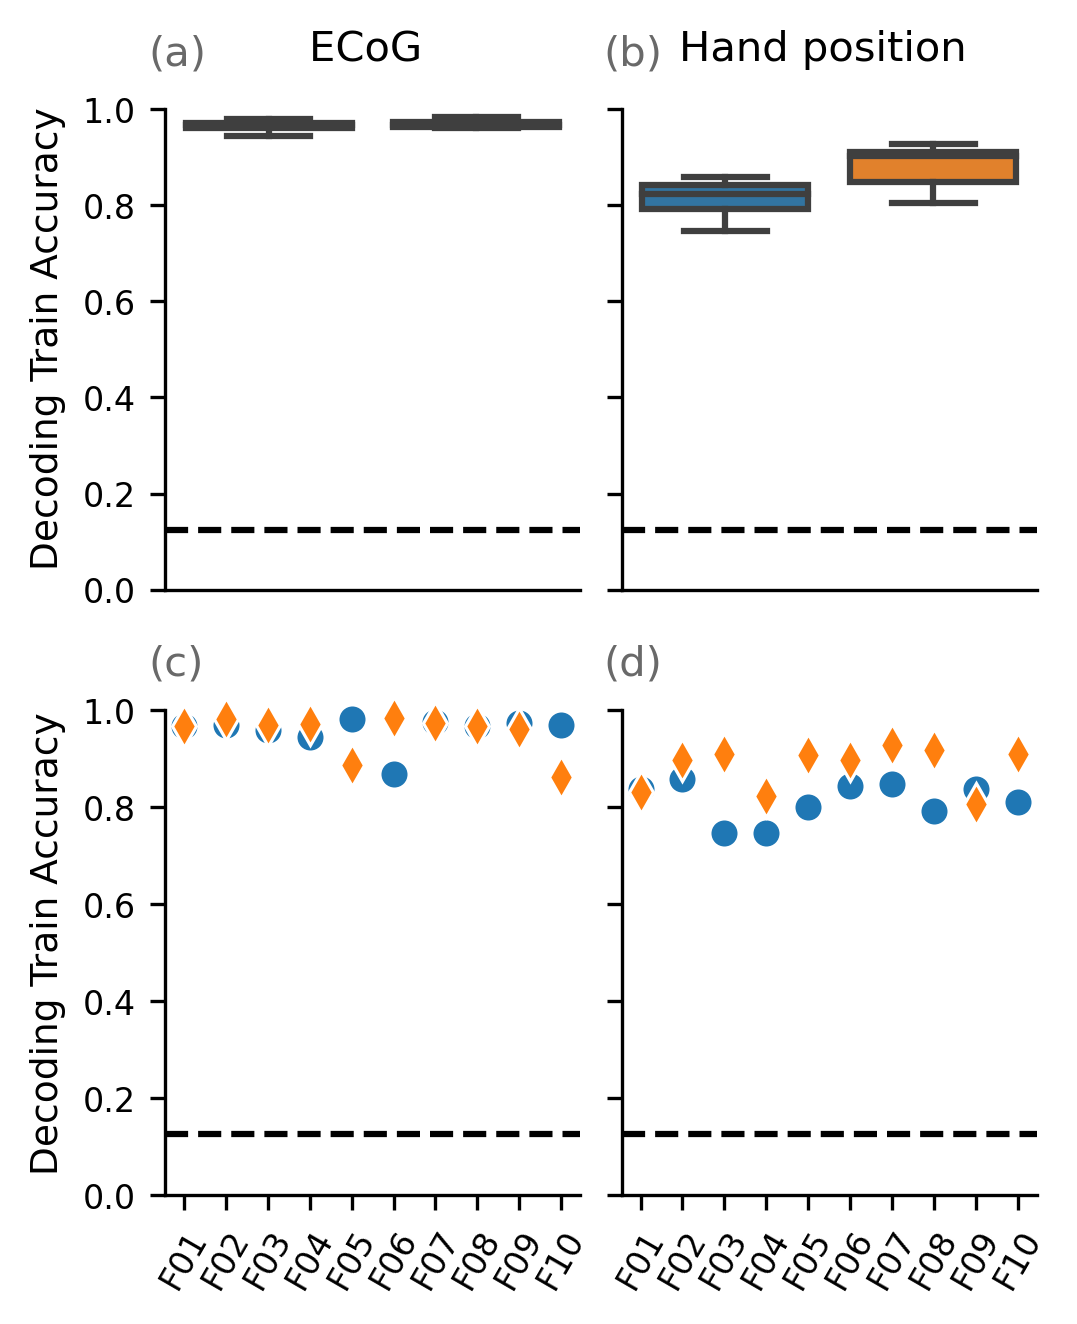

In [52]:
if measure == 'acc':
    # get per-fold results
    n_cls = 8
    row_labels = ['ECoG ', 'Hand position ']
    group_labels = np.array(['Supervised', 'Supervised',
                                # 'Unimodal', 'Unimodal',
                                'Cross-modal\n(with pose)', 'Cross-modal\n(with ECoG)'])
    sbjs_all = ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10']
    meas_l = 'Decoding '+dat_type_d[dat_type]+'Accuracy'

    n_modspair = n_modalities
    dat = np.zeros((n_folds, len(subfolders)*n_modspair))
    for f, fold in enumerate(subfolders):
        dat_fld = []
        for i in range(n_folds):
            dat[i,f*n_modspair:(f*n_modspair+n_modspair)] = accs[f,:,i]

    inds_neur = np.array([0, 2])
    inds_pose = np.array([1, 3])
    group_labs_neur = group_labels[inds_neur]
    group_labs_pose = group_labels[inds_pose]
    xticks_sbj = ['F'+str(val+1).zfill(2) for val in range(n_folds)]
    df_neur = pd.DataFrame(dat[:,inds_neur], columns = group_labs_neur, index = xticks_sbj)
    df_pose = pd.DataFrame(dat[:,inds_pose], columns = group_labs_pose, index = xticks_sbj)
    df_emg, group_labs_emg = None, None
    df_list = [df_neur, df_pose, df_emg]
    grp_list = [group_labs_neur, group_labs_pose, group_labs_emg]

    # plot per-fold results
    ncols = 2 if dataset != 'eeg_balance_all3_v2' else 3
    hspace = 0.2
    ylim_lo = 0.45 if dataset in ['naturalistic', 'eeg_arm'] else 0
    ylim_hi = 1.05
    yticks = [0.5, 0.75, 1] if dataset in ['naturalistic', 'eeg_arm'] else [0,.2,.4,.6,.8,1]
    width = 7.5/2 if dataset != 'eeg_balance_all3_v2' else 4
    height = 5.5 if dataset == 'eeg_balance_all3_v2' else 4.9

    fig, ax = plt.subplots(2,ncols,dpi=300,figsize=(width, height),
                        gridspec_kw={'wspace': 0.1, 'hspace': hspace})
    palette = sns.color_palette()
    curr_palette = palette[:len(group_labs_neur)]
    curr_palette = curr_palette if dataset != 'eeg_balance_all3_v2' else itemgetter(0,1,2,3,5)(palette)

    # Neural 
    plt_acc_boxscatter(df_neur, n_cls=n_cls, yticks=yticks, ylim_lo=ylim_lo, axes=(ax[0,0], ax[1,0]),
                    row_label=row_labels[0], meas_l=meas_l, group_labs=group_labs_neur,
                    curr_palette=curr_palette, yticklabs=True, use_stats=use_stats, ylim_hi=ylim_hi,
                    measure=measure, sbjs_all=sbjs_all, dataset=dataset, xticks_sbj=xticks_sbj,
                    verbosity=verbosity, markers=markers)

    # Pose
    plt_acc_boxscatter(df_pose, n_cls=n_cls, yticks=yticks, ylim_lo=ylim_lo, axes=(ax[0,1], ax[1,1]),
                    row_label=row_labels[1], meas_l=meas_l, group_labs=group_labs_pose,
                    curr_palette=curr_palette, yticklabs=False, use_stats=use_stats, ylim_hi=ylim_hi,
                    measure=measure, sbjs_all=sbjs_all, dataset=dataset, xticks_sbj=xticks_sbj,
                    verbosity=verbosity, markers=markers)

    for col in range(ncols):
        for row in range(2):
            ax[row,col].spines['right'].set_visible(False)
            ax[row,col].spines['top'].set_visible(False)    

    add_letters(dataset)
    plt.show()

    # save results
    fig_sp = rootpth+'figs/'
    fig_name = dataset+'_sup_run15-16_'+measure+'_'+dat_type+'_perfold'
    if save_fig:
        fig.savefig(fig_sp+fig_name+'.png',
                    transparent= True,dpi=300,
                    bbox_inches = 'tight', pad_inches = 0.01,
                    )

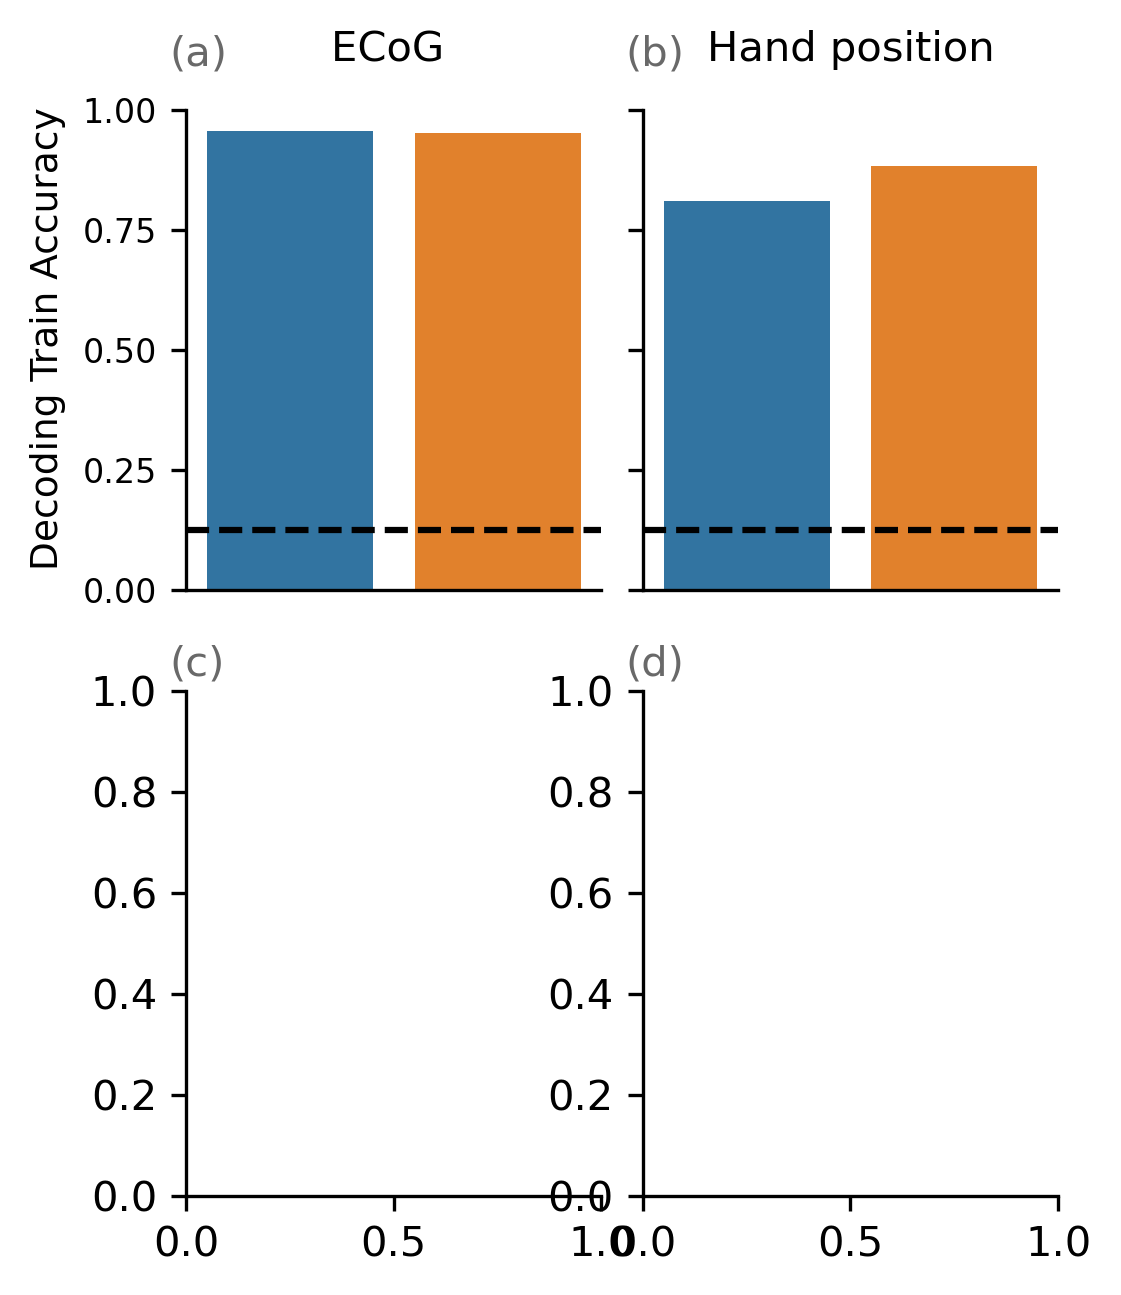

In [53]:
# get fold-averaged results
for i, dst in enumerate(datasets):
    n_cls, row_labels, group_labels, sbjs_all, n_modspair = load_dataset_params(dst)
    meas_l = select_meas(measure, dat_type_d, dat_type)

    subfolders = subfolders_d[dst]

    df_list, grp_list = obtain_dfs(subfolders, sbjs_all, n_modspair, group_labels,
                                dst, rootpth, dat_type_d_num, dat_type,
                                subfolders_d, measure=measure)

    if i > 0:
        df_neur2, df_pose2, df_emg2 = df_list
        group_labs_neur2, group_labs_pose2, group_labs_emg2 = grp_list
        group_labs_neur = np.hstack((group_labs_neur,group_labs_neur2[-1]+'\n(All 3)'))
        group_labs_pose = np.hstack((group_labs_pose,group_labs_pose2[-1]+'\n(All 3)'))
        group_labs_emg = np.hstack((group_labs_emg,group_labs_emg2[-1]+'\n(All 3)'))
        df_neur[group_labs_neur[-1]] = df_neur2[group_labs_neur2[-1]]
        df_pose[group_labs_pose[-1]] = df_pose2[group_labs_pose2[-1]]
        df_emg[group_labs_emg[-1]] = df_emg2[group_labs_emg2[-1]]
    else:
        df_neur, df_pose, df_emg = df_list
        group_labs_neur, group_labs_pose, group_labs_emg = grp_list

# plot fold-averaged results
ncols = 2 if dataset != 'eeg_balance_all3_v2' else 3
hspace = 0.2
ylim_lo = 0.45 if dataset in ['naturalistic', 'eeg_arm'] else 0
ylim_hi = 1.05
yticks = [0.5, 0.75, 1] if dataset in ['naturalistic', 'eeg_arm'] else [0,.25,.5,.75,1]
width = 7.5/2 if dataset != 'eeg_balance_all3_v2' else 4
height = 5.5 if dataset == 'eeg_balance_all3_v2' else 4.9

xticks_sbj = ['P'+str(val+1).zfill(2) for val in range(len(sbjs_all))]
fig, ax = plt.subplots(2,ncols,dpi=300,figsize=(width, height),
                       gridspec_kw={'wspace': 0.1, 'hspace': hspace})
palette = sns.color_palette()
curr_palette = palette[:len(group_labs_neur)]
curr_palette = curr_palette if dataset != 'eeg_balance_all3_v2' else itemgetter(0,1,2,3,5)(palette)

# Neural
axes=(ax[0,0], ax[1,0])
row_label=row_labels[0]
group_labs=group_labs_neur
yticklabs=True
sns.barplot(data=df_neur, ax = axes[0], palette=curr_palette)
if measure == 'acc':
    axes[0].axhline(1/n_cls,linestyle='--',color='k')
if yticks:
    axes[0].set_yticks(yticks)
axes[0].set_ylim([ylim_lo, ylim_hi])
axes[0].spines['left'].set_bounds((ylim_lo, 1))
if row_label:
    axes[0].set_title(row_label, fontsize=10)
if yticklabs:
    axes[0].set_ylabel('Decoding '+meas_l, fontsize=9)
else:
    axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', labelsize=8)
for tick in axes[0].get_xticklabels():
    tick.set_rotation(40)
axes[0].set_xticks([])

# Pose
axes=(ax[0,1], ax[1,1])
row_label='Hand position'
group_labs=group_labs_pose
yticklabs=False
sns.barplot(data=df_pose, ax = axes[0], palette=curr_palette)
if measure == 'acc':
    axes[0].axhline(1/n_cls,linestyle='--',color='k')
if yticks:
    axes[0].set_yticks(yticks)
axes[0].set_ylim([ylim_lo, ylim_hi])
axes[0].spines['left'].set_bounds((ylim_lo, 1))
if row_label:
    axes[0].set_title(row_label, fontsize=10)
if yticklabs:
    axes[0].set_ylabel(meas_l, fontsize=9)
else:
    axes[0].set_yticklabels([])
axes[0].tick_params(axis='both', labelsize=8)
for tick in axes[0].get_xticklabels():
    tick.set_rotation(40)
axes[0].set_xticks([])

for col in range(ncols):
    for row in range(2):
        ax[row,col].spines['right'].set_visible(False)
        ax[row,col].spines['top'].set_visible(False)    

add_letters(dataset)
plt.show()

# save results
fig_sp = rootpth+'figs/'
fig_name = dataset+'_sup_run15-16_'+measure+'_'+dat_type
if save_fig:
    fig.savefig(fig_sp+fig_name+'.png',
                transparent= True,dpi=300,
                bbox_inches = 'tight', pad_inches = 0.01,
                )


In [54]:
df_list

[     Supervised  Unimodal
 P01    0.956858       NaN
 P02         NaN  0.951522,
      Supervised  Unimodal
 P01    0.811638       NaN
 P02         NaN  0.882546,
 None]

### Print mean+-SD for each condition

In [55]:
def print_pm(df_in):
    means = df_in.mean()
    stds = df_in.std()
    for i in range(len(means)):
        print('{0:.2f}+-{1:.2f}'.format(means[i],stds[i]))

print('Neural')
print_pm(df_neur)
print('')
print('Pose')
print_pm(df_pose)

if df_emg is not None:
    print('')
    print('EMG')
    print_pm(df_emg)

Neural
0.96+-nan
0.95+-nan

Pose
0.81+-nan
0.88+-nan


## Show numeric v-measure results

In [56]:
meas_tab = 'vscore'
df_out = None
ncols = 2 if dataset != 'eeg_balance_all3_v2' else 3
if dataset != 'eeg_balance_all3_v2':
    df_out = comput_meas_table(meas_tab, subfolders_d, dataset, sbjs_all, rootpth, dat_type_d_num,
                               dat_type, group_labels, ncols, row_labels, n_modspair)
df_out


['Supervised', 'Unimodal']
['Supervised', 'Unimodal']


,Supervised,Unimodal
ECoG,0.92+-nan,0.92+-nan
Pose,0.76+-nan,0.83+-nan
